# Composing Contracts II

Toying with ideas from [How to Write a Financial Contract](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.7885) by S. L. Peyton Jones and J-M. Eber. There is an old version of the paper [Composing Contracts:An Adventure in Financial Engineering](https://www.cs.tufts.edu/~nr/cs257/archive/simon-peyton-jones/contracts.pdf) by Jones, Eber and Seward. Some code for this version can be found in [Composing Contracts](./Composing%20Contracts.ipynb).

In [1]:
from typing import TypeVar, Generic
from dataclasses import dataclass, asdict, astuple
from abc import ABC, abstractmethod
from datetime import datetime

## Observable Floats and Visitor ABC

In [2]:
class ObservableFloat(ABC):
    pass

In [3]:
@dataclass
class Konst(ObservableFloat):
    constant: float

@dataclass
class Stock(ObservableFloat):
    ticker: str

In [4]:
T = TypeVar('T')

class ObservableFloatVisitor(ABC, Generic[T]):
    
    @abstractmethod
    def konst(self, constant: float) -> T: pass

    @abstractmethod
    def stock(self, ticker: str) -> T: pass
    
    def __call__(self, observable: ObservableFloat) -> T:
        if isinstance(observable, Konst):
            return self.konst(observable.constant)
        elif isinstance(observable, Stock):
            return self.stock(observable.ticker)
        else:
            raise TypeError(f'Unknown observable float type "{type(contract).__name__}"')

## Observable Booleans and Visitor ABC

In [5]:
class ObservableBool(ABC):
    pass

In [6]:
@dataclass
class KonstBool(ObservableBool):
    constant: bool

@dataclass
class At(ObservableBool):
    date: datetime

In [7]:
T = TypeVar('T')

class ObservableBoolVisitor(ABC, Generic[T]):
    
    @abstractmethod
    def konst(self, constant: bool) -> T: pass

    @abstractmethod
    def at(self, date: datetime) -> T: pass
    
    def __call__(self, observable: ObservableBool) -> T:
        if isinstance(observable, KonstBool):
            return self.konst(observable.constant)
        elif isinstance(observable, At):
            return self.at(observable.date)
        else:
            raise TypeError(f'Unknown observable bool type "{type(contract).__name__}"')

## Contracts and Visitor ABC

In [8]:
class Contract(ABC):
    pass

In [9]:
@dataclass
class Zero(Contract):
    pass

@dataclass
class One(Contract):
    currency: str

@dataclass
class Give(Contract):
    contract: Contract

@dataclass
class And(Contract):
    contract1: Contract
    contract2: Contract

@dataclass
class Or(Contract):
    contract1: Contract
    contract2: Contract

@dataclass
class Cond(Contract):
    observable: ObservableBool
    contract1: Contract
    contract2: Contract    

@dataclass
class Scale(Contract):
    observable: ObservableFloat
    contract: Contract

@dataclass
class When(Contract):
    observable: ObservableBool
    contract: Contract

@dataclass
class Anytime(Contract):
    observable: ObservableBool
    contract: Contract

@dataclass
class Until(Contract):
    observable: ObservableBool
    contract: Contract

In [10]:
T = TypeVar('T')

class ContractVisitor(ABC, Generic[T]):

    @abstractmethod
    def zero(self, acquisition_date: datetime) -> T: pass

    @abstractmethod
    def one(self, acquisition_date: datetime, currency: str) -> T: pass

    @abstractmethod
    def give(self, acquisition_date: datetime, contract: Contract) -> T: pass

    @abstractmethod
    def and_(self, acquisition_date: datetime, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def or_(self, acquisition_date: datetime, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def cond(self, acquisition_date: datetime, observable: ObservableBool, contract1: Contract, contract2: Contract) -> T: pass

    @abstractmethod
    def scale(self, acquisition_date: datetime, observable: ObservableFloat, contract: Contract) -> T: pass

    @abstractmethod
    def when(self, acquisition_date: datetime, observable: ObservableBool, contract: Contract) -> T: pass

    @abstractmethod
    def anytime(self, acquisition_date: datetime, observable: ObservableBool, contract: Contract) -> T: pass

    @abstractmethod
    def until(self, acquisition_date: datetime, observable: ObservableBool, contract: Contract) -> T: pass

    def __call__(self, acquisition_date: datetime, contract: Contract) -> T:
        if isinstance(contract, Zero):
            return self.zero(acquisition_date)
        elif isinstance(contract, One):
            return self.one(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Give):
            return self.give(acquisition_date, **contract.__dict__)
        elif isinstance(contract, And):
            return self.and_(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Or):
            return self.or_(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Cond):
            return self.cond(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Scale):
            return self.scale(acquisition_date, **contract.__dict__)
        elif isinstance(contract, When):
            return self.when(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Anytime):
            return self.anytime(acquisition_date, **contract.__dict__)
        elif isinstance(contract, Until):
            return self.until(acquisition_date, **contract.__dict__)
        else:
            raise TypeError(f'Unknown contract type "{type(contract).__name__}"')

## A Simple Printer Implementation of Visitors

In [11]:
class ObservableFloatPrinter(ObservableFloatVisitor[str]):
    def konst(self, constant: float) -> str: return str(constant)
    def stock(self, ticker: str) -> str: return f'"{ticker}"'

In [12]:
class ObservableBoolPrinter(ObservableBoolVisitor[str]):
    def konst(self, constant: bool) -> str: return str(constant)
    def at(self, date: datetime) -> str: return f'"{date}"'

In [13]:
class ContractPrinter(ContractVisitor[str]):
    
    def __init__(self,
                 observable_float_visitor: ObservableFloatVisitor[str],
                 observable_bool_visitor: ObservableBoolVisitor[str]) -> None:
        self.observable_float_visitor = observable_float_visitor
        self.observable_bool_visitor = observable_bool_visitor
    
    def zero(self, acquisition_date) -> str: return 'zero'
    def one(self, acquisition_date, currency: str) -> str: return f'one {currency}'
    def give(self, acquisition_date, contract: Contract) -> str: return f'give ({self(acquisition_date, contract)})'
    def and_(self, acquisition_date, contract1: Contract, contract2: Contract) -> str: return f'and ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def or_(self, acquisition_date, contract1: Contract, contract2: Contract) -> str: return f'or ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def cond(self, acquisition_date, observable: ObservableBool, contract1: Contract, contract2: Contract) -> T: return f'cond ({self.observable_bool_visitor(observable)}) ({self(acquisition_date, contract1)}) ({self(acquisition_date, contract2)})'
    def scale(self, acquisition_date, observable: ObservableFloat, contract: Contract) -> str: return f'scale {self.observable_float_visitor(observable)} ({self(acquisition_date, contract)})'
    def when(self, acquisition_date, observable: ObservableBool, contract: Contract) -> T: return f'when {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'
    def anytime(self, acquisition_date, observable: ObservableBool, contract: Contract) -> T: return f'anytime {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'
    def until(self, acquisition_date, observable: ObservableBool, contract: Contract) -> T: return f'until {self.observable_bool_visitor(observable)} ({self(acquisition_date, contract)})'


## Examples

In [14]:
def zcb(maturity: datetime, notional: float, currency: str):
    return When(At(maturity), Scale(Konst(notional), One(currency)))

In [15]:
def european(maturity: datetime, contract: Contract):
    return When(At(maturity), Or(contract, Zero()))

In [16]:
mybond1 = zcb(datetime(2030, 7, 14), 1000000, 'EUR')
mybond1

When(observable=At(date=datetime.datetime(2030, 7, 14, 0, 0)), contract=Scale(observable=Konst(constant=1000000), contract=One(currency='EUR')))

In [17]:
printer = ContractPrinter(ObservableFloatPrinter(), ObservableBoolPrinter())
printer(None, mybond1)

'when "2030-07-14 00:00:00" (scale 1000000 (one EUR))'

In [18]:
asdict(mybond1)

{'observable': {'date': datetime.datetime(2030, 7, 14, 0, 0)},
 'contract': {'observable': {'constant': 1000000},
  'contract': {'currency': 'EUR'}}}

In [19]:
astuple(mybond1)

((datetime.datetime(2030, 7, 14, 0, 0),), ((1000000,), ('EUR',)))

In [20]:
dict(**mybond1.__dict__)

{'observable': At(date=datetime.datetime(2030, 7, 14, 0, 0)),
 'contract': Scale(observable=Konst(constant=1000000), contract=One(currency='EUR'))}

In [21]:
def european_put(ticker: str, currency: str, maturity: datetime, strike: float):
    return When(At(maturity), Or(
        And(Give(Scale(Stock(ticker), One(currency))), Scale(Konst(strike), One(currency))),
        Zero()))

In [22]:
myput1 = european_put('ABC Eqty', 'USD', datetime(2030, 7, 14), 123.45)
myput1

When(observable=At(date=datetime.datetime(2030, 7, 14, 0, 0)), contract=Or(contract1=And(contract1=Give(contract=Scale(observable=Stock(ticker='ABC Eqty'), contract=One(currency='USD'))), contract2=Scale(observable=Konst(constant=123.45), contract=One(currency='USD'))), contract2=Zero()))

In [23]:
printer(None, myput1)

'when "2030-07-14 00:00:00" (or (and (give (scale "ABC Eqty" (one USD))) (scale 123.45 (one USD))) (zero))'

## Simulated Cashflows

In [24]:
import numpy as np

In [25]:
cashflow_dtype = np.dtype([('date', 'datetime64[D]'), ('currency', np.string_, 3), ('value', np.float64)])
cashflow_dtype

dtype([('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [26]:
cf = np.array([(datetime(2030, 7, 14), 'USD', 123.45), (datetime(2031, 7, 14), 'USD', 123.45)], cashflow_dtype)
cf = cf.reshape((cf.size, 1))
cf

array([[('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 123.45)]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [27]:
multicf = np.concatenate((cf, cf, cf), axis=1)
multicf.shape

(2, 3)

In [28]:
multicf['date'] == np.datetime64(datetime(2031, 7, 14))

array([[False, False, False],
       [ True,  True,  True]])

In [29]:
multicf[multicf['date'] == np.datetime64(datetime(2031, 7, 14))]['value'] = 888 # does not modify
multicf

array([[('2030-07-14', b'USD', 123.45), ('2030-07-14', b'USD', 123.45),
        ('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 123.45), ('2031-07-14', b'USD', 123.45),
        ('2031-07-14', b'USD', 123.45)]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

In [30]:
multicf['value'][multicf['date'] == np.datetime64(datetime(2031, 7, 14))] = 999 # does modify
multicf

array([[('2030-07-14', b'USD', 123.45), ('2030-07-14', b'USD', 123.45),
        ('2030-07-14', b'USD', 123.45)],
       [('2031-07-14', b'USD', 999.  ), ('2031-07-14', b'USD', 999.  ),
        ('2031-07-14', b'USD', 999.  )]],
      dtype=[('date', '<M8[D]'), ('currency', 'S3'), ('value', '<f8')])

## Simulated Stochastic Processes

In [31]:
import numpy as np


class BrownianMotion:
    '''Brownian Motion (Wiener Process) with optional drift.'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        W = rnd.normal(size=(n, t.size))
        W_drift = (W * np.sqrt(dt) * self.sigma + self.mu * dt).T
        return np.cumsum(W_drift, axis=0)


class GeometricBrownianMotion:
    '''Geometric Brownian Motion.(with optional drift).'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T

## Fixed Grid Simulation Model

In [32]:
N = 100
rnd = np.random.RandomState(123)
T = 5
grid = np.linspace(0, T, T * 4)

In [33]:
model = {
    'ABC Eqty': 123 * GeometricBrownianMotion(0.02, 0.2).simulate(grid, N, rnd)
}

In [34]:
import matplotlib.pyplot as plt

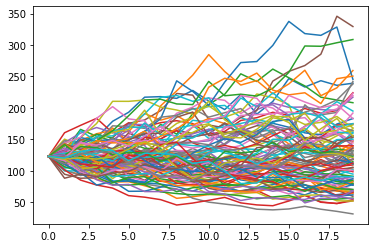

In [35]:
plt.plot(model['ABC Eqty']);